# Load libraries

In [1]:
import pandas as pd
#from sklearn.cross_validation import KFold,StratifiedKFold
#import datetime
import numpy as np
#from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
#from sklearn import metrics
#from sklearn.metrics import roc_auc_score
#from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn import metrics
from sklearn.cross_validation import StratifiedKFold
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

#import seaborn as sns
#import pickle
#from sklearn import metrics
#import sys

import matplotlib.pyplot as plt

C:\Users\edve\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
plt.style.use('ggplot')

%matplotlib inline

#  
# Load data

In [3]:
df = pd.read_csv('../../data/cs-training.csv')

In [4]:
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
df.rename(columns={df.columns[0]:'id'}, inplace=True)

In [6]:
df.head()

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [7]:
len(df)

150000

In [8]:
df.mean(axis=0)

id                                      75000.500000
SeriousDlqin2yrs                            0.066840
RevolvingUtilizationOfUnsecuredLines        6.048438
age                                        52.295207
NumberOfTime30-59DaysPastDueNotWorse        0.421033
DebtRatio                                 353.005076
MonthlyIncome                            6670.221237
NumberOfOpenCreditLinesAndLoans             8.452760
NumberOfTimes90DaysLate                     0.265973
NumberRealEstateLoansOrLines                1.018240
NumberOfTime60-89DaysPastDueNotWorse        0.240387
NumberOfDependents                          0.757222
dtype: float64

In [9]:
df.rename(columns={'SeriousDlqin2yrs':'target'}, inplace=True)

features = [c for c in df.columns if c not in ['id','target']]

#  
# Replacing NANs

In [10]:
for c in df.columns:
    nan_count = len(df[df[c].isnull()])
    if nan_count>0:
        print(c, nan_count, 1.0*nan_count/len(df))

('MonthlyIncome', 29731, 0.19820666666666667)
('NumberOfDependents', 3924, 0.02616)


In [11]:
print(min(df['MonthlyIncome']))
print(min(df['NumberOfDependents']))

0.0
0.0


In [12]:
df = df.fillna(-1)

#  
# Functions

In [38]:
def getResultsWithCV(dataframe, 
                     clf, 
                     target_column, 
                     features, 
                     folds=5, 
                     balance_classes=False, 
                     balancing_factor=3):

    kf = StratifiedKFold(y=dataframe[target_column], 
                           n_folds=folds, 
                           shuffle=True,
                           random_state=42)
    
    if list(dataframe.index.values) != list(range(len(dataframe))):
        print("ERROR WITH INDEX")
        return 0
  
    AUCs = [] 
    for train_index, test_index in kf:
         
        # Train the model
        dataframe_train = dataframe.iloc[train_index]
        if balance_classes==True:
            class_1_samples = len(dataframe_train[dataframe_train[target_column]==1])
            dataframe_train = pd.concat([dataframe_train[dataframe_train[target_column]==0].sample(n=int(class_1_samples*balancing_factor)),
                                         dataframe_train[dataframe_train[target_column]==1]])     
        X_train = dataframe_train[features].values
        y_train = dataframe_train[target_column].values     
        clf.fit(X_train, y_train)
               
        # Calculate the predictions
        dataframe_test = dataframe.iloc[test_index]
        X_test = dataframe_test[features].values
        y_test = dataframe_test[target_column].values   
        
        
        predictions_proba = clf.predict_proba(X_test)[:,1]
        dataframe.loc[test_index, 'prediction_proba'] = predictions_proba
      
        fold_auc = metrics.roc_auc_score(y_test,predictions_proba)
        AUCs.append(fold_auc)

        #print( round(fold_auc,4))
    return( np.mean(AUCs), np.std(AUCs))

#  
# Boost - no features scaling

In [35]:
features = [c for c in df.columns if c not in ['id','target']]

In [36]:
n_estimators = [100,150,200,250,300]
learning_rates = [0.05, 0.1,  0.2]
max_depths = [1,2,3,5]
min_impurity_splits = [(1e-7)/2,1e-7,(1e-7)*2]
class_balancing_factors = [0.5,0.8,1,1.2,2,3,5,10]

In [ ]:
#model2meanStd = {}

for n_estimator in n_estimators:
    for learning_rate in learning_rates:
        for max_depth in max_depths:
            for min_impurity_split in min_impurity_splits:
                for class_balancing_factor in class_balancing_factors:
                    print(n_estimator,learning_rate,max_depth,min_impurity_split,class_balancing_factor),
                    model = GradientBoostingClassifier(n_estimators=n_estimator,
                                                       learning_rate=learning_rate,
                                                       max_depth=max_depth,
                                                       min_impurity_split=min_impurity_split)
                    (auc_mean,auc_std) = getResultsWithCV(dataframe=df, 
                                                 clf=model, 
                                                 target_column='target', 
                                                 features=features, 
                                                 folds=5, 
                                                 balance_classes=True, 
                                                 balancing_factor=class_balancing_factor)
                    print (auc_mean,auc_std)
                    #model2meanStd[n_estimators] = (auc_mean,auc_std)

 (100, 0.05, 1, 5e-08, 0.5) (0.85551392756639133, 0.0052833283923950734)
(100, 0.05, 1, 5e-08, 0.8) (0.85415757874483877, 0.0053779920009552175)
(100, 0.05, 1, 5e-08, 1) (0.85321473109436852, 0.0054185813843880279)
(100, 0.05, 1, 5e-08, 1.2) (0.8527863247899875, 0.0068266889950079537)
(100, 0.05, 1, 5e-08, 2) (0.85127337945687953, 0.0073066644582205492)
(100, 0.05, 1, 5e-08, 3) (0.85142266385285192, 0.0091345949310360705)
(100, 0.05, 1, 5e-08, 5) (0.85019507836443642, 0.010833294673419182)
(100, 0.05, 1, 5e-08, 10) (0.84804866331026463, 0.0097442078107728182)
(100, 0.05, 1, 1e-07, 0.5) (0.84305872464618881, 0.010452852203692497)
(100, 0.05, 1, 1e-07, 0.8) (0.8428615698125691, 0.013398040455447341)
(100, 0.05, 1, 1e-07, 1) (0.84279705354092227, 0.014936491667650358)
(100, 0.05, 1, 1e-07, 1.2) (0.84155694094055067, 0.015613179265341831)
(100, 0.05, 1, 1e-07, 2) (0.84178733610372924, 0.016228864985364893)
(100, 0.05, 1, 1e-07, 3) (0.84585072370939007, 0.010306223876653206)
(100, 0.05, 1, 

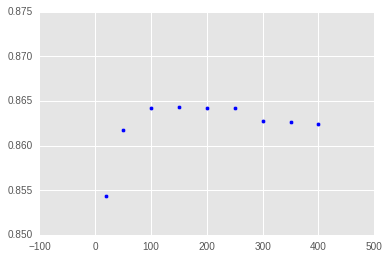

In [60]:
for (estimator,results) in model2meanStd.items():
    plt.scatter(estimator,results[0])

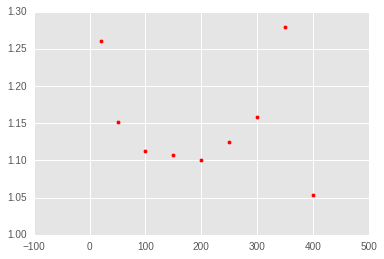

In [61]:
for (estimator,results) in model2meanStd.items():
    plt.scatter(estimator,results[1]*200,c='r')

#  
#  
# Generate the solution

In [62]:
df_toPredict = pd.read_csv('../../data/cs-test.csv')
df_toPredict = df_toPredict.fillna(-1)

In [63]:
df.groupby('target').count()[['id']]

,id
target,
0,139974
1,10026


In [65]:
clf = GradientBoostingClassifier(n_estimators=200)

### Generate 10 datasets using sampling where class are balanced  and use the mean of the 10 predictions

In [66]:
df_target1 = df[df['target']==1].copy().reset_index(drop=True)
df_target0 = df[df['target']==0].copy()

In [67]:
#dfs = []
for i in range(10):
    print(i) #just added
    df_balanced = pd.concat([df_target1,
                             df_target0.sample(n=len(df_target1))]).reset_index(drop=True)
    clf.fit(df_balanced[features],
           df_balanced['target'])
    df_toPredict['Probability'+str(i)] = clf.predict_proba(df_toPredict[features])[:,1]
    

0
1
2
3
4
5
6
7
8
9


In [68]:
df_toPredict.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,...,Probability0,Probability1,Probability2,Probability3,Probability4,Probability5,Probability6,Probability7,Probability8,Probability9
0,1,-1.0,0.885519,43,0,0.177513,5700.0,4,0,0,...,0.497515,0.484593,0.514760,0.512758,0.468555,0.541621,0.516301,0.505471,0.492174,0.538217
1,2,-1.0,0.463295,57,0,0.527237,9141.0,15,0,4,...,0.479280,0.454399,0.357787,0.423093,0.454664,0.374319,0.513709,0.374143,0.455867,0.406493
2,3,-1.0,0.043275,59,0,0.687648,5083.0,12,0,1,...,0.134342,0.147749,0.156626,0.153177,0.136374,0.141616,0.145873,0.172736,0.173187,0.141362
3,4,-1.0,0.280308,38,1,0.925961,3200.0,7,0,2,...,0.554288,0.541085,0.561594,0.566923,0.565656,0.555151,0.557026,0.554870,0.527672,0.555432
4,5,-1.0,1.000000,27,0,0.019917,3865.0,4,0,0,...,0.624148,0.585709,0.614193,0.641473,0.594752,0.617336,0.680067,0.624035,0.609328,0.572535


In [69]:
df_toPredict['Probability'] = df_toPredict[['Probability'+str(i) for i in range(10)]].mean(axis=1)

In [70]:
df_toPredict.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,...,Probability1,Probability2,Probability3,Probability4,Probability5,Probability6,Probability7,Probability8,Probability9,Probability
0,1,-1.0,0.885519,43,0,0.177513,5700.0,4,0,0,...,0.484593,0.514760,0.512758,0.468555,0.541621,0.516301,0.505471,0.492174,0.538217,0.507196
1,2,-1.0,0.463295,57,0,0.527237,9141.0,15,0,4,...,0.454399,0.357787,0.423093,0.454664,0.374319,0.513709,0.374143,0.455867,0.406493,0.429375
2,3,-1.0,0.043275,59,0,0.687648,5083.0,12,0,1,...,0.147749,0.156626,0.153177,0.136374,0.141616,0.145873,0.172736,0.173187,0.141362,0.150304
3,4,-1.0,0.280308,38,1,0.925961,3200.0,7,0,2,...,0.541085,0.561594,0.566923,0.565656,0.555151,0.557026,0.554870,0.527672,0.555432,0.553970
4,5,-1.0,1.000000,27,0,0.019917,3865.0,4,0,0,...,0.585709,0.614193,0.641473,0.594752,0.617336,0.680067,0.624035,0.609328,0.572535,0.616358


In [71]:
df_toPredict.rename(inplace=True, columns={df_toPredict.columns[0]:'Id'})

In [72]:
df_toPredict[['Id','Probability']].to_csv('predictions.csv',index=False)